## 추세추종 전략 백테스트
추세추종이란 주가가 동일한 방향으로 지속될 것이라는데 베팅하는 것이다. 추세추종, 혹은 모멘텀 전략은 월스트리트에서 가장 오래된 투자전략 중 하나로써, 무려 1838년에 출간된 책에도 설명될 만큼 역사가 길고, 현재에도 가장 많이 사용되는 전략 중 하나이다.

## 마켓 타이밍 전략
대표적인 추세추종 전략인 이동평균선을 이용한 트레이딩의 백테스트를 진행해보도록 하겠다. 메브 파버(Meb Faber)는 본인의 논문을 통해, 시점 선택(Market Timing) 전략을 사용할 경우 단순히 매수 후 보유하는 것 대비 극심한 하락장에서 낙폭을 줄일 수 있으며, 이로 인해 위험 대비 수익률을 올릴 수 있다고 설명하였다. 논문에서 말하는 시점 선택의 투자 규칙은 다음과 같다.

- 주가 > 10개월이동평균 = 매수
- 주가 < 10개월이동평균 = 매도 및 현금보유
즉 주가가 10개월 이동평균 보다 위에 있다는 것은 상승추세를 의미하므로 매수 포지션을, 10개월 이동평균 보다 아래에 있다는 것을 하락추세를 의미하므로 현금 보유를 통해 하락 방어를 하고자 한다. 먼저 해당 규칙을 미국 S&P 500를 추종하는 SPY ETF에 적용하는 예제를 살펴보겠다.

In [16]:
import talib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import bt
import yfinance as yf

In [17]:
mpl.rcParams['font.family'] = 'Malgun Gothic' # window
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000

### 데이터 가져오기

In [65]:
data = bt.get('ZN=F', start='2010-01-01')
# data = yf.download('^TNX', start='2023-06-01', interval='1h')
data.tail()

[*********************100%***********************]  1 of 1 completed


,znf
Date,
2023-06-29,112.125000
2023-06-30,112.265625
2023-07-03,111.937500
2023-07-05,111.359375
2023-07-06,111.250000


먼저 apply() 함수 내부에 SMA()을 이용해 200일(10개월) 이동평균을 구한다.

In [66]:
sma = data.apply(lambda x: talib.SMA(x, 200))

In [67]:
# import bt

bt_sma = bt.Strategy('Timing', [
    bt.algos.SelectWhere(data > sma),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

bt_sma_backtest = bt.Backtest(bt_sma, data)

bt.algos.SelectWhere()는 입력값이 True 일때만 투자를 하도록 정의한다. 즉, ETF 가격에 해당하는 data가 이동평균에 해당하는 sma 보다 클 때에만 투자를 한다. 나머지는 위에서 살펴본 것들과 동일한다.

In [68]:
def buy_and_hold(data, name):

    # 벤치마크 전략 생성(Buy & Hold Strategy)
    bt_strategy = bt.Strategy(name, [        
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.RunOnce(),
        bt.algos.Rebalance()
    ])
    # Return the backtest
    return bt.Backtest(bt_strategy, data)


# 벤치마크 전략 백테스트
stock = buy_and_hold(data[['znf']], name='stock')

# 두개 백테스트 동시에 실행
bt_sma_result = bt.run(bt_sma_backtest, stock)

- buy_and_hold() 함수를 통해 단순 매수 후 보유의 경우를 정의한다. 
- bt.algos.RunOnce()는 리밸런싱이 없이 처음 상태가 그대로 유지되는 것이다.
- SPY의 매수 후 보유 전략을 생성한다.
- 앞에서 생성된 추세추종 전략과, 매수 후 보유의 백테스트를 동시에 실행한다.

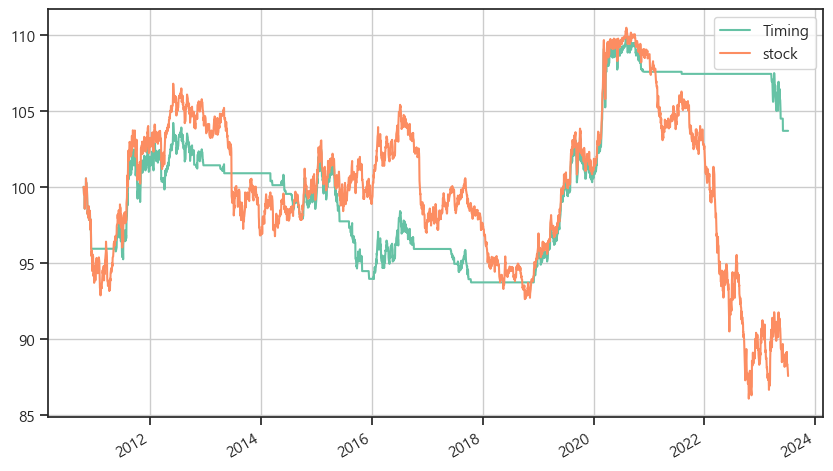

In [69]:
bt_sma_result.prices.iloc[201:, ].rebase().plot(figsize=(10, 6))
plt.show()

추세추종 전략의 경우 이동평균 계산을 위해 처음 200 일간은 투자가 되지 않으므로 매수 후 보유 전략과 시작 시점이 일치하지 않는다. 따라서 200일이 지난 후부터의 데이터를 선택한다. 그 후 rebase() 함수를 이용해 데이터의 시작시점을 다시 100으로 만든다.

추세추종 전략을 사용할 경우 2000년 IT 버블이나 2008년 금융위기시 하락폭이 제한된다. 즉 하락추세가 시작되면 주식을 모두 매도하여, 추가적인 하락을 방어한다.

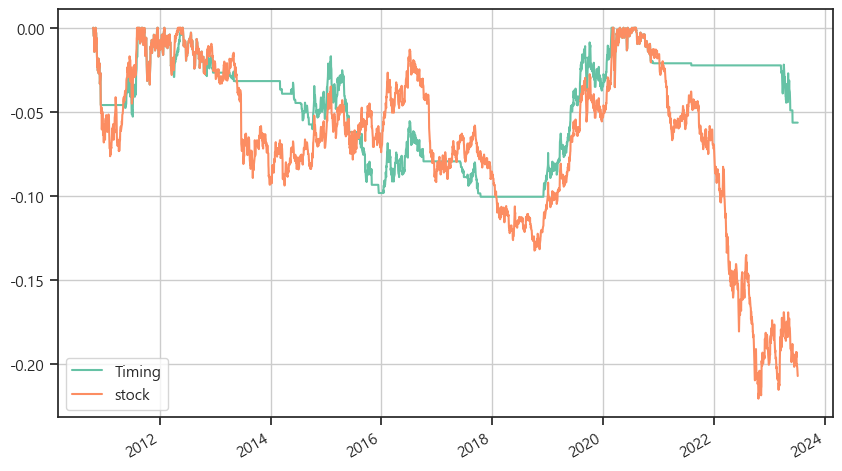

In [70]:
bt_sma_result.prices.iloc[201:, ].rebase().to_drawdown_series().plot(
    figsize=(10, 6))
plt.show()

to_drawdown_series() 함수는 낙폭(drawdown)을 계산한다. 앞서 언급한 것 처럼 추세추종 전략을 사용할 경우 하락 방어가 우수하다. 반면 코로나19 사태 직후인 2020년 3월의 경우 추세추종 전략은 추세가 깨져 투자를 하지 않지만, 주식 시장이 급반등 함에 따라 매수 후 보유 전략의 상승분을 따라가지 못하기도 하였다.

In [71]:
bt_sma_result.stats.loc[[
    'total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe', 'daily_sortino'
]]

,Timing,stock
total_return,0.038063,-0.037054
cagr,0.00277,-0.002792
daily_vol,0.034082,0.054028
max_drawdown,-0.10056,-0.220674
calmar,0.027549,-0.012654
daily_sharpe,0.098326,-0.02482
daily_sortino,0.147603,-0.0408


수익률 자체는 단순 보유전략(stock)이 높지만 변동성이나 MDD와 같은 위험지표는 마켓 타이밍 전략(Timing)이 훨씬 낮다. 결과적으로 위험을 고려한 성과 지표는 마켓 타이밍 전략이 더 우수하다.

## 파라미터 최적화
과연 200일(10개월) 이동평균을 사용하는 것이 최적일까? 혹은 다른 값을 사용했을 때 수익률이 더 좋을수 있지 않을까? 이러한 질문은 트레이더들이 항상 하는 질문이다. '200일'과 같이 우리가 임의로 정하는 변수를 파라미터(parameter)라 하며, 성과가 최대화 되는 파라미터를 찾는 것을 파라미터 최적화라고 한다. 트레이딩에서 이러한 파라미터 최적화는 매우 중요한 작업이다. 앞선 마켓 타이밍 전략에서 이동평균을 계산할 때 사용하는 일수를 변경해가며 수익률을 확인해보도록 하자.

In [72]:
# import talib
# import bt

def timing(data, n):

    sma = data.apply(lambda x: talib.SMA(x, n))
    stragety = bt.Strategy(n, [
        bt.algos.SelectWhere(data > sma),        
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ])

    backtest = bt.Backtest(stragety, data)

    return (backtest)

n_10 = timing(data, 10)
n_20 = timing(data, 20)
n_60 = timing(data, 60)
n_100 = timing(data, 100)
n_150 = timing(data, 150)
n_200 = timing(data, 200)
n_250 = timing(data, 250)

result = bt.run(n_10,n_20, n_60, n_100, n_150, n_200, n_250)

1. 이동평균을 계산한 후, 백테스트를 생성하는 부분을 timing() 함수로 작성한다.
2. 20일부터 250일까지 이동평균을 이용한 마켓타이밍 모델의 백테스트를 생성한다.
3. 모든 백테스트를 한번에 실행한다.

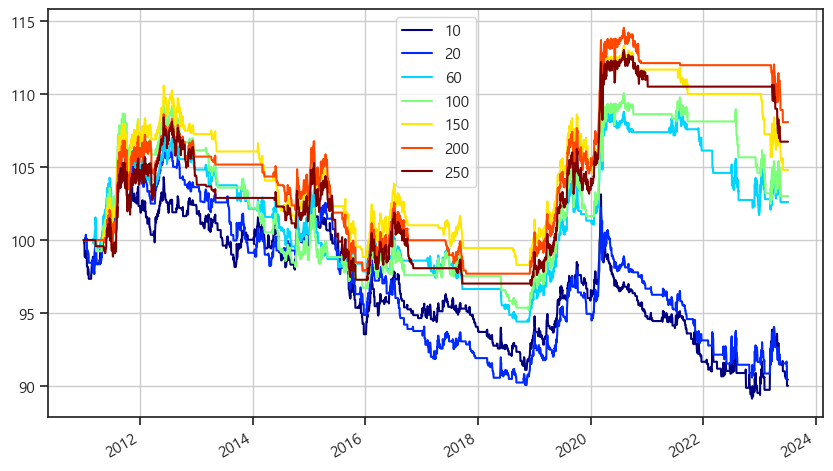

In [73]:
from matplotlib import cm

result.prices[250:].rebase().plot(figsize=(10, 6), colormap=cm.jet)
plt.show()

누적수익률을 확인해보면 단기 보다는 장기 이동평균을 사용할 수록 우수한 성과를 기록한다. 그러나 예를 들어 250일 이동평균이 최고의 수익률을 기록한다고 이것이 최적의 파라미터라고 말하기는 힘들다. 장기 이동평균을 사용하는 것이 단기 이동평균을 사용하는 것보다 성과가 좋은 이유는, 장기 이동평균이 장기적인 추세를 더 잘 반영하기 때문일 수 있다. 그러나 같은 장기 이동평균에서도 250일이 200일 보다 우수한 것은 단순히 우연의 결과일 수 있으며, 백테스트 기간을 다르게 하면 전혀 다른 결과가 나타날 수도 있다.

백테스트 기간에서 최적화된 파라미터가 향후에도 최고의 수익률을 기록할 것이라는 생각은 위험하다. 백테스트에서는 엄청나게 우수한 성과를 보였던 전략을 찾아 용기있게 실제 투자에 나섰다가 과최적화의 저주에 빠져 실망스러운 수익률로 이어지는 경우도 종종 목격한다. 따라서 모델에 사용되는 파라미터의 갯수는 최대한 작게, 그리고 인샘플(in-sample) 뿐만 아니라 아웃오브샘플(out-of-sample) 테스트에서도 뛰어난 성과를 보이는 파라미터를 택하는 것이 좋다.

## 롱숏 전략
지금까지는 주가가 이동평균선 위에 있을 때 매수하며 그렇지 않으면 현금을 보유하는 '롱온리(Long-Only)' 전략에 대한 백테스트를 실시했다. 그러나 추세추종 전략은 상승추세에 대한 베팅뿐만 아니라 공매도, 인버스 ETF 혹은 선물매도 포지션을 통해 하락추세에도 베팅할 수 있다.

흔히 단기 이동평균선이 중장기 이동평균선을 뚫고 올라가는 골든크로스의 경우 상승추세에 대한 신호를, 반대로 뚫고 내려가는 데드크로스의 경우 하락추세에 대한 신호를 나타낸다. 과연 이러한 신호를 이용해 트레이딩 했을 때 성과가 어떤지 살펴보도록 하자.

In [74]:
# import talib

# data = price[['SPY']]
SMA_200 = data.apply(lambda x: talib.SMA(x, 200))
SMA_60 = data.apply(lambda x: talib.SMA(x, 60))
SMA_250 = data.apply(lambda x: talib.SMA(x, 250))
SMA_20 = data.apply(lambda x: talib.SMA(x, 20))
SMA_10 = data.apply(lambda x: talib.SMA(x, 10))


# stock_data['SMA_20'] = talib.SMA(stock_data['Close'],20)
# stock_data['SMA_60'] = talib.SMA(stock_data['Close'],60)
# stock_data['SMA_120'] = talib.SMA(stock_data['Close'],120)

먼저 장기추세에 해당하는 200일 지수 이동평균과 단기추세에 해당하는 60일 지수 이동평균을 구한다.

In [75]:
signal = SMA_200.copy()
signal[SMA_10 >= SMA_60] = 1
signal[SMA_10 < SMA_60] = -1
signal[signal.isnull()] = 0

만일 60일 이동평균이 200일 이동평균보다 위에 있을 경우(골든크로스) 100% 투자 즉 매수를 하며, 반대의 경우(데드크로스) -100% 투자 즉 매도를 한다. 이동평균을 계산하기 위한 처음 200일 부분은 데이터가 없으므로 포지션을 0으로 둔다.

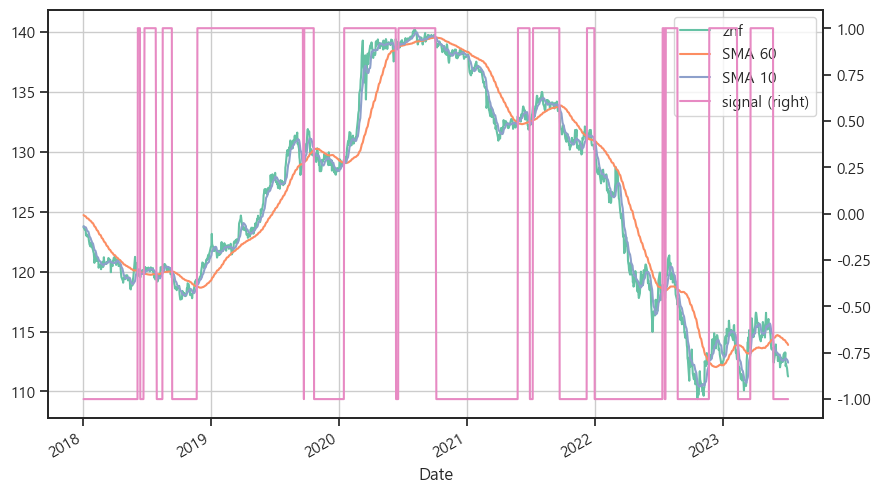

In [76]:
# import matplotlib.pyplot as plt

bind = pd.concat([data, SMA_60, SMA_10, signal], axis=1)
bind.columns = ['znf', 'SMA 60', 'SMA 10', 'signal']
bind.loc['2018':].plot(figsize=(10, 6), secondary_y=['signal'])
plt.show()

2018년 이후부터 주가와 각 이동평균선, 신호를 그림으로 나타내보면 단기 이동평균선(SMA 60)이 장기 이동평균선(SMA 200) 위에 있을 경우에는 매수(1), 그렇지 않을 때는 매도(-1)를 하는 것이 확인된다. 이제 해당 전략의 백테스트를 실행해보자.

C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


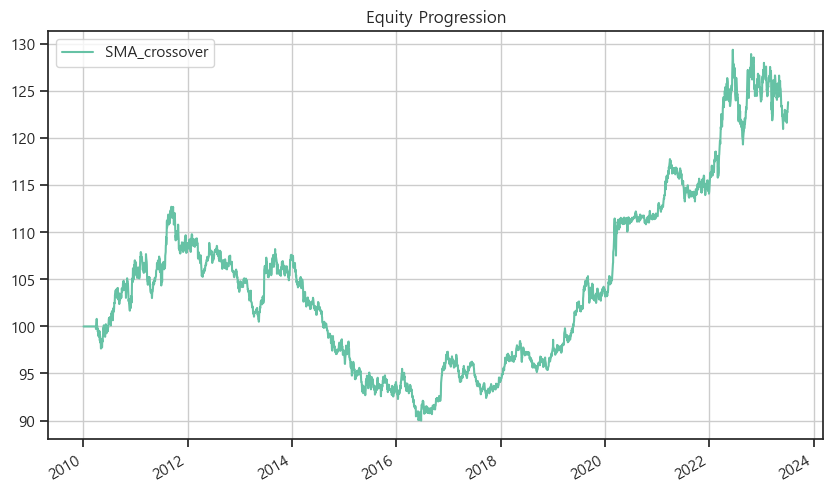

In [77]:
# import bt

strategy = bt.Strategy(
    'SMA_crossover',
    [bt.algos.SelectAll(),
     bt.algos.WeighTarget(signal),
     bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

bt.algos.WeighTarget() 함수 내에 각 시점별 비중을 입력하면, 해당 시점과 비중에 맞춰 리밸런싱이 실시된다. 이를 통해 해당 패키지에서 함수 형태로 제공하지 않는 매우 복잡한 전략의 백테스트도 시기별 비중을 직접 계산해 얼마든지 실행할 수 있다.

결과를 살펴보면 장기간 동안 우상향을 하지만 2011년, 2015~16년, 2020년 등에는 엄청난 낙폭을 기록하기도 했다. 월별 및 연도별 수익률을 확인해보자.

In [ ]:
result.display_monthly_returns()

display_monthly_returns() 메서드를 통해 월단위 및 연단위 수익률을 확인할 수 있다. 2020년에는 코로나 이후 주가가 급등했음에도 불구하고, 롱숏 전략은 -20.55%의 큰 손실을 기록하였다. 왜 이런 결과가 나왔는지 해당 구간을 자세히 살펴보도록 하자.

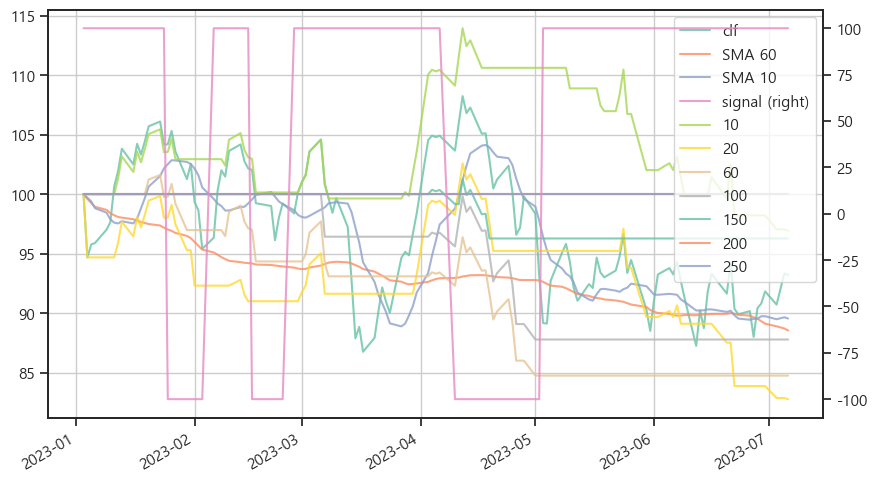

In [62]:
pd.concat([bind, result.prices],
          axis=1).loc['2023'].rebase().plot(figsize=(10, 6),
                                            secondary_y=['signal'],
                                            alpha=0.8)
plt.show()

코로나 사태로 인해 2020년 3월부터 미국 주식(SPY)은 급격하게 하락하기 시작했으며, 3월 중순에는 60일 이동평균선이 200일 이동평균선을 하회함에 따라 숏 신호가 발생하였다. 그러나 공교롭게도 해당 시점부터 시장은 바닥을 다지고 엄청난 상승을 보였으며, 전략(SMA_crossover)에서는 숏 포지션을 취하고 있는 만큼 손실이 발생하기 시작한다. 6월이 되서야 다시 골든크로스가 발생하여 롱 포지션으로 전환하였지만, 불과 3달동안 복구할 수 없을 정도의 손실을 입게 되었다. 실제로 추세추종 전략을 사용하는 많은 펀드들이 2020년 3월부터 6월까지 막대한 손실을 입었다. 2020년 1~3월에는 롱 포지션에서 손실을 입고, 3월부터는 숏 포지션에서 손실을 입어 양방향에서 모두 손실을 입은 것이다.

만일 롱온리 전략을 택했다면 3월부터 6월까지 단순히 수익을 얻지 못한것에 그쳤겠지만, 숏 포지션으로 인해 손실이 배가 된 것이다. 이처럼 숏 베팅은 하락 시장에서도 돈을 벌 수 있게 해주지만, 예상치 못한 급반등이 나올 경우 손실을 입히는 양날의 검이 되기도 한다. 이를 방지하기 위해 트레이딩에서는 다양한 신호의 결합, 손실제한(스탑로스, 로스컷) 등을 추가하기도 한다.